In [1]:
# ゴールデンクロス, デッドクロスのみを作成し、その結果で資産計算を行うデモファイル

In [2]:
# pandas_datareaderをインストール
# !pip install pandas_datareader

In [3]:
# ライブラリのインポート
# from datetime import datetime, timedelta
# import talib as ta
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
%matplotlib inline

# 必要な関数を定義
'''
データの取り込みと調整を行う関数
'''
def import_data(kind, reference='yahoo'):
    data_master = data.DataReader(kind, reference, '2000-01-01', end)
    data_master.reset_index(drop=False, inplace=True)
    data_master['Date'] = pd.to_datetime(data_master['Date'])
    return data_master

'''
テクニカル指標を導入する関数
'''
def data_arrange(data_master):
    # 警告が出ないようにコピーしたデータフレームを使う
    data_technical = data_master.copy()
    # ロジックについての配列を作成
    data_logic = pd.DataFrame()
    data_graph = []
    # テクニカル指標を作成するカラムを指定して変数sに格納
    s = data_technical['Close']
    # for文を使ってテクニカル指標を新たに作成
    for i in windows:
        # 単純移動平均
        data_technical['sma_' + str(i)] = s.rolling(window=i).mean()
    
    # ロジック作成
    n = 0
    for i in windows[::-1]:
        for j in windows:
            if i > j:
                # GC,DCの買いシグナルと売りシグナル
                n += 1
                # ロジック名を定義
                logic1 = 'logic' + str('{0:05d}'.format(n))
                # 2本の移動平均の差分を計算
                data_technical['sma_' + str(i)+'-'+str(j)] = data_technical['sma_' + str(i)] - data_technical['sma_'+str(j)]
                # 短期移動平均線を長期移動平均線が上回ったときに売りシグナルを立たせる
                data_technical[logic1 + '_sell'] = (data_technical['sma_' + str(i) + '-' + str(j)] * data_technical['sma_' + str(i) + '-' + str(j)].shift(1) < 0) & (data_technical['sma_'+str(i)] > data_technical['sma_'+str(j)])
                # 長期移動平均線を短期移動平均線が上回ったときに買いシグナルを立たせる
                data_technical[logic1 + '_buy'] = (data_technical['sma_' + str(i) + '-' + str(j)] * data_technical['sma_' + str(i) + '-' + str(j)].shift(1) < 0) & (data_technical['sma_' + str(i)] < data_technical['sma_'+str(j)])
                # ロジックについてのデータフレームを作成
                # 各ロジック番号とそれが意味する内容についてまとめた表が作成される
                data_logic = pd.concat([data_logic, pd.DataFrame([logic1, 'sma_slope_' + str(i) + '-' + str(j)]).T])
                # グラフ作成のための情報が入ったリストを作成
                data_graph.append([logic1, ['sma_' + str(i), 'sma_' + str(j)]])

    # NaNがある行を削除
    data_technical = data_technical.dropna(how='any')
    # True,Falseを0,1に変換
    data_technical.replace({False: 0, True: 1}, inplace=True)
    # data_technicalのindexを整理
    start_timestamp = pd.to_datetime(start)
    data_technical = data_technical.set_index('Date')
    data_technical = data_technical.loc[start_timestamp:, :]
    data_technical.reset_index(drop=False, inplace=True)
    data_technical['idx_technical'] = data_technical.index
    # data_logicのデータを整理
    data_logic.columns = ['logic_number', 'logic_name']
    data_logic.reset_index(drop=True, inplace=True)
    return data_technical, data_logic, data_graph

'''
資産計算を行う関数
'''
def close_order(asset, have_position, order_price, cnt_win, cnt_lose, price, diff_price, unit):
    if(have_position == 'buy'):  # 買いポジションの場合
        diff_price = price - order_price - spreed
    elif(have_position == 'sell'):  # 売りポジションの場合
        diff_price = order_price - price - spreed
    if(diff_price > 0):  # 勝った場合
        cnt_win += 1
        result = 'win'
    else:
        cnt_lose += 1
        result = 'lose'

    asset = asset + diff_price * unit
    have_position = 'neutral'
    return asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit

def check_price(data_technical, use_data):
    # 結果を記載するデータフレーム
    data_result = pd.DataFrame()
    # 警告が出ないようにデータフレームをコピー
    data = data_technical.copy()
    # 資産
    asset = ASSET
    # 各々の変数の初期値
    have_position = 'neutral'
    order_price, diff_price, cnt_win, cnt_lose, unit = 0, 0, 0, 0, 0
    # テクニカル指標のカラム名
    col_buy = use_data + '_buy'
    col_sell = use_data + '_sell'

    # for文を使ってそれぞれの取引の計算結果を調べる
    # ルールとしては、買いシグナルと売りシグナルのいずれかが立ったときに取引を行い、利確または損切りの価格を満たしたときに取引を終了させる
    # 取引に使用する口数は、その時の資産で購入可能な最大値を使用
    # 取引中(利確損切り手続きを待っているとき)は、新たな取引のシグナルが立っていても取引は行わない
    for idx_technical, open_price, buy_signal, sell_signal in zip(data['idx_technical'], data['Close'], data[col_buy], data[col_sell]):
        if(have_position == 'buy'):
            if(open_price - order_price > profit_diff):  # 買い利益確定
                start_position = have_position
                asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit = close_order(asset, have_position, order_price, cnt_win, cnt_lose, open_price, diff_price, unit)
                data_result = data_result.append(pd.DataFrame([ask_time, data['Date'][idx_technical], ask_idx, idx_technical, order_price, price, result, start_position, diff_price, asset, unit]).T)
            elif open_price - order_price < loss_diff:  # 買い損切り
                start_position = have_position
                asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit = close_order(asset, have_position, order_price, cnt_win, cnt_lose, open_price, diff_price, unit)
                data_result = data_result.append(pd.DataFrame([ask_time, data['Date'][idx_technical], ask_idx, idx_technical, order_price, price, result, start_position, diff_price, asset, unit]).T)
        elif(have_position == 'sell'):
            if order_price - open_price > profit_diff:  # 売り利益確定
                start_position = have_position
                asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit  = close_order(asset, have_position, order_price, cnt_win, cnt_lose, open_price, diff_price, unit)
                data_result = data_result.append(pd.DataFrame([ask_time, data['Date'][idx_technical], ask_idx, idx_technical, order_price, price, result, start_position, diff_price, asset, unit]).T)
            elif order_price - open_price < loss_diff:  # 売り損切り
                start_position = have_position
                asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit  = close_order(asset, have_position, order_price, cnt_win, cnt_lose, open_price, diff_price, unit)
                data_result = data_result.append(pd.DataFrame([ask_time, data['Date'][idx_technical], ask_idx, idx_technical, order_price, price, result, start_position, diff_price, asset, unit]).T)
        elif(have_position == 'neutral'):  # ポジションを持っていない場合
            if (buy_signal == 1):  # 買いシグナルが起きた場合
                # 買い注文
                have_position = 'buy'
                order_price = data['Close'][idx_technical]
                ask_idx = idx_technical
                ask_time = data['Date'][idx_technical]
                unit = (asset - asset % open_price) / open_price
            elif (sell_signal == 1):  # 売りシグナルが起きた場合
                # 売り注文
                have_position = 'sell'
                order_price = data['Close'][idx_technical]
                ask_idx = idx_technical
                ask_time = data['Date'][idx_technical]
                unit = (asset - asset % open_price) / open_price
    # resultのデータフレームを整理
    if (data_result.shape[0] == 0):
        # 取引回数が0回だった時の処理
        print('使用したテクニカル指標では取引回数が0回でした。')
        return asset, cnt_win, cnt_lose, data_result
    else:
        # 取引が行われた時の処理
        data_result.columns = ['ask_time', 'bid_time', 'ask_idx', 'bid_idx', 'ask_price', 'bid_price', 'result', 'order_position', 'diff_price', 'asset', 'unit']
        data_result.reset_index(drop=True, inplace=True)
        return asset, cnt_win, cnt_lose, data_result
    
'''
資産計算を行なった結果をグラフ化する関数
'''
def data_plot_asset(data_result):
    # 資産の増減のグラフを作成
    # 始点を追加する
    data_result_first = pd.DataFrame(['--', pd.to_datetime(start), '--', '--', '--', '--', '--', 'neutral', '--', ASSET, '--']).T
    data_result_first.columns = ['ask_time', 'bid_time', 'ask_idx', 'bid_idx', 'ask_price', 'bid_price', 'result', 'order_position', 'diff_price', 'asset', 'unit']
    data_result_graph = pd.concat([data_result_first, data_result])
    register_matplotlib_converters()
    # 資産の推移を折れ線グラフで可視化
    plt.figure(figsize=(20, 5))
    plt.plot(data_result_graph['bid_time'], data_result_graph['asset'], marker='o')
    plt.title('Changes in Assets')
    plt.ticklabel_format(style='plain',axis='y')
    plt.grid()
    plt.show()
    
'''
資産計算の詳細をグラフ化する関数
'''
def data_plot_info(data_technical, data_result, data_graph, use_data):
    # グラフの最大値と最小値の差を求める
    close_max = data_technical['Close'].max()
    close_min = data_technical['Close'].min()
    close_diff = close_max - close_min

    # 資産運用結果を勝敗について分けたデータフレーム
    results_win = data_result[data_result['result'] == 'win']
    results_lose = data_result[data_result['result'] == 'lose']

    # グラフ描画
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))
    ax = ax.flatten()
    # 折線グラフ
    ax[0].plot(data_technical['Date'], data_technical['Close'], label='Close data')
    for i in data_graph:
        if(i[0] == use_data):
            for col in i[1]:
                ax[1].plot(data_technical['Date'], data_technical[col], label=col)
    # 散布図
    ax[0].scatter(data_result['ask_time'], data_result['ask_price'], marker='o', color='white', s=150, label='asking point', linewidths=2, edgecolors='black', alpha=0.5)
    ax[0].scatter(results_win['bid_time'], results_win['bid_price'], marker='o', color='red', s=150, label='bidding point (win)', linewidths=2, edgecolors='red', alpha=0.5)
    ax[0].scatter(results_lose['bid_time'], results_lose['bid_price'], marker='o', color='skyblue', s=150, label='bidding point (lose)', linewidths=2, edgecolors='blue', alpha=0.5)

    # 注釈の記載
    for start_date, start_price, end_date, end_price in zip(results_win['ask_time'], results_win['ask_price'], results_win['bid_time'], results_win['bid_price']):
        ax[0].annotate(s='', xy=(end_date, end_price), xytext=(start_date, start_price), fontsize=14, arrowprops=dict(facecolor='firebrick', shrink=0.05))
    for start_date, start_price, end_date, end_price in zip(results_lose['ask_time'], results_lose['ask_price'], results_lose['bid_time'], results_lose['bid_price']):
        ax[0].annotate(s='', xy=(end_date, end_price), xytext=(start_date, start_price), fontsize=14, arrowprops=dict(facecolor='skyblue', shrink=0.05))
    for text, end_date, end_price in zip(data_result['result'], data_result['bid_time'], data_result['bid_price']):
        ax[0].text(end_date, end_price + 0.03*close_diff, text, fontsize=13, horizontalalignment='left', verticalalignment='center')
    for text, start_date, start_price in zip(data_result['order_position'], data_result['ask_time'], data_result['ask_price']):
        ax[0].text(start_date, start_price + 0.03*close_diff, text, fontsize=13, horizontalalignment='right', verticalalignment='center')

    # グラフのタイトル、ラベルなどを設定
    ax[0].set_title('Finance Result Graph')
    ax[0].set_xlabel('Date');ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Close')
    ax[0].grid(True);ax[1].grid(True)
    ax[0].legend();ax[1].legend()
    plt.show()

In [4]:
# 開始日時と終了日時
start, end = '2021-01-01', '2021-12-01'
# 使用する銘柄
kind = '^N225'
# スタート時の資産
ASSET = 1000000
# 手数料
spreed = 50
# 利確をする価格差(正の値)
profit_diff = 300
# 損切をする価格差(負の値)
loss_diff = -300

# windows: 移動平均日数
windows = [20, 10]

# データのインポートを行う
data_master = import_data(kind=kind)
# テクニカル指標を作成
data_technical, data_logic, data_graph = data_arrange(data_master)

In [5]:
# テクニカル指標の対応表についてのデータフレームの表示
data_logic

,logic_number,logic_name
0,logic00001,sma_slope_20-10


,ask_time,bid_time,ask_idx,bid_idx,ask_price,bid_price,result,order_position,diff_price,asset,unit
0,2021-02-05 00:00:00,2021-02-08 00:00:00,23,24,28779.2,29388.5,lose,sell,-659.311,977583,34
1,2021-02-10 00:00:00,2021-02-15 00:00:00,26,28,29562.9,30084.2,win,buy,471.221,993134,33
2,2021-03-05 00:00:00,2021-03-11 00:00:00,41,45,28864.3,29211.6,lose,sell,-397.32,979625,34
3,2021-03-22 00:00:00,2021-03-24 00:00:00,52,54,29174.2,28405.5,lose,buy,-818.631,952610,33
4,2021-03-31 00:00:00,2021-04-02 00:00:00,59,61,29178.8,29854,lose,sell,-725.199,929404,32
5,2021-04-08 00:00:00,2021-04-20 00:00:00,65,73,29709,29100.4,lose,buy,-658.6,908987,31
6,2021-04-22 00:00:00,2021-04-30 00:00:00,75,80,29188.2,28812.6,win,sell,325.539,919079,31
7,2021-06-02 00:00:00,2021-06-15 00:00:00,100,109,28946.1,29441.3,win,buy,445.16,932879,31
8,2021-06-24 00:00:00,2021-07-07 00:00:00,116,125,28875.2,28366.9,win,sell,458.281,947544,32
9,2021-08-16 00:00:00,2021-08-20 00:00:00,150,154,27523.2,27013.2,lose,buy,-559.939,928506,34


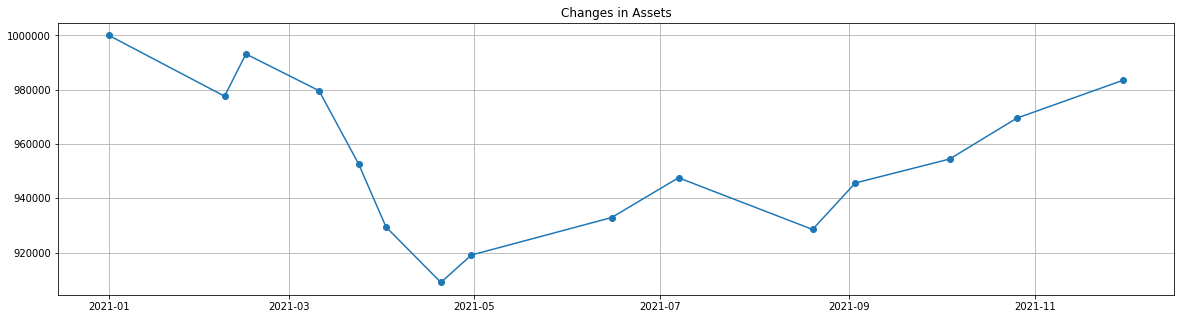

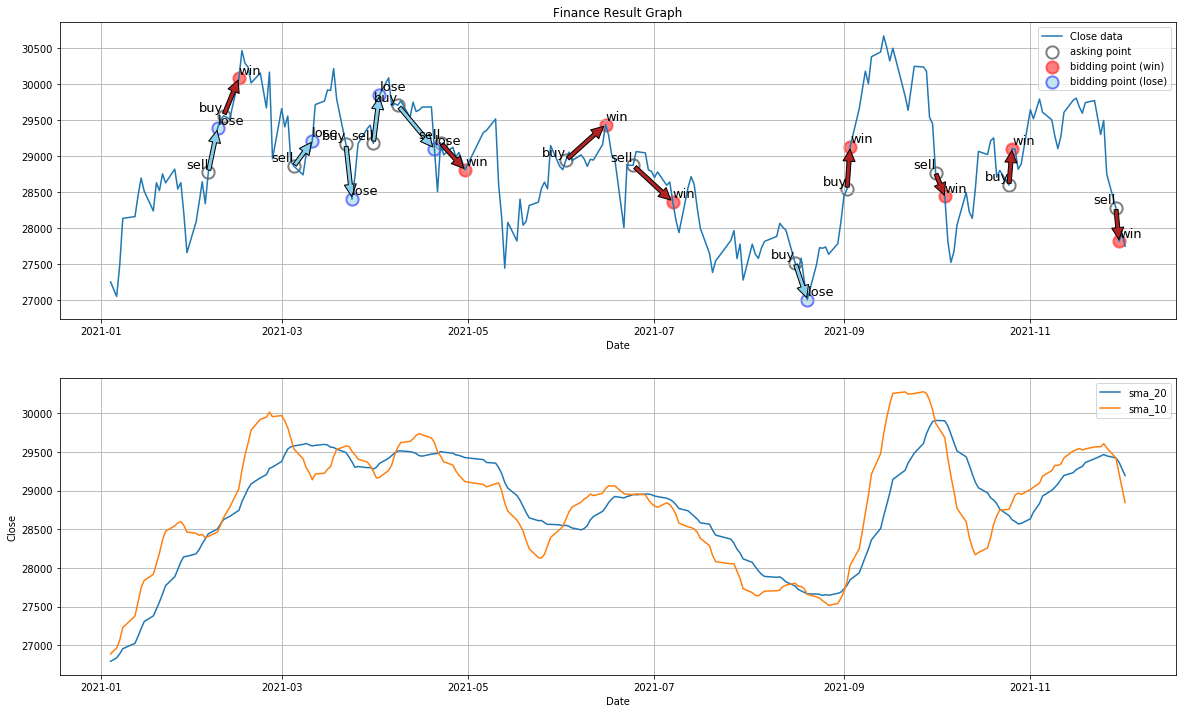

In [6]:
# use_dataにロジック番号を指定
use_data = 'logic00001'
# 以下の関数を実行すると結果が表示されるようになる
asset, cnt_win, cnt_lose, data_result = check_price(data_technical, use_data=use_data)
display(data_result)
data_plot_asset(data_result)
data_plot_info(data_technical, data_result, data_graph, use_data=use_data)